# PPT 3 / 31
# Embedding Matching 

## Algorithm
1. choose anchor
    * (S) global randomly, target randomly
    * (S) dimension reduction + cluster on raw text embedding & select center
    * (U) Graph emb + cluster, match center
    * (U) umap + cluster, match center
2. alignment
    1. umap
        * aligned umap
        * umap + procrustes transformation, seperately
        * umap + mlp
    2. statistic
        * baseline
        * umap

### TODO
Exp:
1. different mimic doc emb
    * bert 1234
    * word emb avg
2. different select anchor appoarch
    * random
    * kmeans
    * gaussian mixture
3. mlp learn similarity
4. psuedo anchor
    * umap + hdbscan(center?)
        * problem: same cluster size

Survey:
1. representative data
2. embedding matching

In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
import umap
import umap.plot

In [3]:
from scipy.spatial.distance import cdist
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist

In [4]:
from sklearn.datasets import fetch_20newsgroups
news_data = fetch_20newsgroups(subset='test')
n = len(news_data.data)

In [5]:
print(news_data.target.shape)
news_data.target
news_data.data[0]

(7532,)


'From: v064mb9k@ubvmsd.cc.buffalo.edu (NEIL B. GANDLER)\nSubject: Need info on 88-89 Bonneville\nOrganization: University at Buffalo\nLines: 10\nNews-Software: VAX/VMS VNEWS 1.41\nNntp-Posting-Host: ubvmsd.cc.buffalo.edu\n\n\n I am a little confused on all of the models of the 88-89 bonnevilles.\nI have heard of the LE SE LSE SSE SSEI. Could someone tell me the\ndifferences are far as features or performance. I am also curious to\nknow what the book value is for prefereably the 89 model. And how much\nless than book value can you usually get them for. In other words how\nmuch are they in demand this time of year. I have heard that the mid-spring\nearly summer is the best time to buy.\n\n\t\t\tNeil Gandler\n'

In [6]:
# https://www.sbert.net/docs/pretrained_models.html
main_model_type = 'all-mpnet-base-v1'
mimic_model_type = 'all-distilroberta-v1' 

# all-mpnet-base-v2
# all-distilroberta-v1
#'all-MiniLM-L12-v2' 
# average_word_embeddings_glove.6B.300d

from sentence_transformers import SentenceTransformer
main_model = SentenceTransformer(main_model_type)
mimic_model = SentenceTransformer(mimic_model_type)

In [7]:
main_emb = main_model.encode(news_data.data)
mimic_emb = mimic_model.encode(news_data.data)

## Select Anchor

In [8]:
select_num = 200

### global random k

In [9]:
anchor_index = np.random.choice(np.arange(n), size=select_num, replace=False)
match_index = np.delete(np.arange(n), anchor_index)

anchor_index, match_index

(array([3827, 2084, 5881, 1242, 6093, 2103, 5335, 4491, 4458, 2905, 5289,
        1382, 4397,  383, 5629, 2918, 4287, 6237,  822, 6104,  279, 3319,
        6059,  860, 7045,  241, 6536, 2467,  380, 4561, 5986,  325, 2278,
        1991, 2724,  614, 4169, 5916,  331, 6423, 3934, 4505, 1634,  861,
        3850,  401, 4661, 3814,    5, 5009, 4225, 3043, 1998, 2092, 2370,
         250, 5619, 3854, 2800, 4774, 6704,  928, 1989, 6941, 1969, 7441,
         190, 5389, 3824,  837, 5235, 4243, 7311, 2345, 4622, 7069, 4479,
        4265, 1505, 6977, 7100, 5000, 2602, 1473,   98, 5534, 3787, 6932,
        3466, 7113, 2264, 3904, 2488, 2333, 2529,  324, 3337, 3136, 6111,
        1681, 6744, 5682, 6220, 1221, 6164, 6740, 2559, 5336, 4490, 6478,
        6545, 1264, 1148,   11, 3347, 3830, 2929,  277, 2554, 5193, 6153,
        5310, 4634, 3086, 5272, 5191,  565, 6018, 5650, 6866, 5528, 4554,
        7384, 5664, 2569, 2446, 2427, 4022, 5019, 6156, 3958, 4305, 7454,
        2972, 6177, 6235, 2223, 1223, 

### cluster center
check https://scikit-learn.org/stable/modules/clustering.html

In [10]:
mimic_emb_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', random_state=33).fit_transform(mimic_emb)

#### KMeans

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=select_num, random_state=0).fit(mimic_emb_umap)
kmeans.cluster_centers_

dm = cdist(kmeans.cluster_centers_, mimic_emb_umap, 'euclidean')
anchor_index = np.argmin(dm, axis=1)
match_index = np.delete(np.arange(n), anchor_index)

anchor_index, match_index

(array([1420, 1451, 1445, 3490, 4993, 5199,  772, 2274, 1308, 1785, 6749,
        5447, 7336, 4397, 7453, 6931, 7154, 6814, 5657, 4872,  333,  925,
         908,  863, 4232, 1010, 3575, 6949, 1902, 7502, 5055, 3180, 3227,
        5952, 6145, 6746, 6573, 6938,  577, 6740, 4862, 3442, 6646, 7481,
        1464, 1489, 3300, 4457,  133,   52, 7318, 1625, 7221,  566, 5511,
        1211, 6689, 3293, 4627, 6544,  555, 6751, 5707, 1945, 4960, 5718,
        3122, 3446, 1599, 2351, 5501, 2878, 6395,  727, 2806, 2666, 3630,
         423, 2428, 3387,  747, 3243,  452, 6244, 1684, 3718, 2411, 7003,
        3648, 6336, 3610,  289, 2780, 6074, 5046,  748, 3173, 6293, 2762,
        6061, 1701, 4642, 5695, 7463, 1364, 2609, 2549, 7479, 2417, 1499,
         851,  280, 6510, 7267, 5681,  866, 3809, 3625, 2744, 5414,  977,
        3914, 6865,  636, 1825, 3971, 3894, 2198,   32, 3818, 7509, 2064,
        2081, 3189, 1395, 7020, 1001, 6730,  672, 6033, 3105, 5135, 2148,
        3529, 7379, 1152, 6221,  572, 

#### GaussianMixture

In [12]:
from sklearn.mixture import GaussianMixture

clustering = GaussianMixture(n_components=select_num).fit(mimic_emb_umap)

dm = cdist(clustering.means_, mimic_emb_umap, 'euclidean')
anchor_index = np.argmin(dm, axis=1)
match_index = np.delete(np.arange(n), anchor_index)

anchor_index, match_index

(array([3164, 1641,  795, 7463, 3306, 5226, 3431, 2849, 1193,  431, 5728,
        1425, 4305, 1369, 5049, 6741, 2309, 2762, 2591, 7514,  284, 5707,
        1492, 2198, 6464, 5104, 5273, 6938, 2233, 6646,  996,  948, 2929,
          84,  983, 7271, 7489, 6500, 7459, 4409, 4232, 7369, 6746, 4510,
        6573, 6954, 5588, 6232, 1503, 5952, 1169,  257, 7117, 4407, 3228,
        7361, 2642, 5476,   91,  781, 4637, 4301, 5332, 5208,  554, 2081,
        3116, 6336, 6169, 1005, 5511, 6570, 6136,  910, 6766, 3594, 5749,
        5307, 4769, 7237, 1208, 2391,  672, 2570, 5135,  273,  851, 3546,
        4288, 3914, 6554, 6910, 1785, 3064,  473, 7318,  464, 3714, 6917,
        2609, 5743, 4752, 3723, 2676, 4984,  555, 2781, 2356, 3173, 3648,
        3293, 6822, 5420, 4909, 1001,  119,  845, 7222,  946, 2860, 7371,
        5504, 7460,  941,  727, 6765,  289, 3529, 1031, 1231, 1893, 5235,
        7267, 3732, 1916,  170, 3189, 3235, 4049, 5475, 1825, 7061,  865,
        6221, 5334, 4507, 3204, 4079, 

#### HDBSCAN not good

In [13]:
# import hdbscan

# clusterer = hdbscan.HDBSCAN(min_cluster_size=select_num, min_samples=1000)
# clusterer.fit(mimic_emb_umap)
# clusterer.probabilities_

In [14]:
# plt.hist(clusterer.probabilities_)

In [15]:
# (clusterer.probabilities_ == 1).sum()

In [16]:
# from sklearn.cluster import DBSCAN

# clustering = DBSCAN(eps=0.5, min_samples=5).fit(mimic_emb_umap)
# print(len(clustering.core_sample_indices_))
# anchor_index = clustering.core_sample_indices_
# match_index = np.delete(np.arange(n), anchor_index)

# anchor_index, match_index

## AlignedUMAP

https://umap-learn.readthedocs.io/en/latest/aligned_umap_basic_usage.html

It may happen that it would be beneficial to have different UMAP embeddings aligned with each other. There are several ways to go about doing this. One simple approach is to simply embed each dataset with UMAP independently and then solve for a Procrustes transformation on shared points. An alternative approach is to embed the first dataset and then construct an initial embedding for the second dataset based on locations of shared points in the first embedding and then go from there. A third approach, which will provide better alignments in general, is to optimize both embeddings at the same time with some form of constraint as to how far shared points can take different locations in different embeddings during the optimization. 

> AlignedUMAP is the third one

### Distance
1. Minkowski style metrics
    * euclidean
    * manhattan
    * chebyshev
    * minkowski
2. Miscellaneous spatial metrics
    * canberra
    * braycurtis
    * haversine
3. Normalized spatial metrics
    * mahalanobis
    * wminkowski
    * seuclidean
4. Angular and correlation metrics
    * cosine
    * correlation

In [17]:
relation_dict = {idx: idx for idx in anchor_index}
n_neighbors = 15
min_dist = 0.1
n_components = 2
metric = 'euclidean'

alignment_window_size = 2
alignment_regularisation = 10

In [18]:
aligned_mapper = umap.AlignedUMAP(n_neighbors=n_neighbors,
                                  min_dist=min_dist,
                                  n_components=n_components,
                                  metric=metric,
                                  alignment_window_size=alignment_window_size, \
                                  alignment_regularisation=alignment_regularisation).fit([main_emb, mimic_emb], relations=[relation_dict])

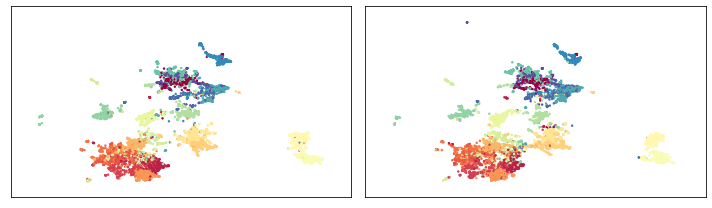

In [19]:
# plot if n_components(dim) == 2
def axis_bounds(embedding):
    left, right = embedding.T[0].min(), embedding.T[0].max()
    bottom, top = embedding.T[1].min(), embedding.T[1].max()
    adj_h, adj_v = (right - left) * 0.1, (top - bottom) * 0.1
    return [left - adj_h, right + adj_h, bottom - adj_v, top + adj_v]

if n_components == 2:
    fig, axs = plt.subplots(1,2, figsize=(10, 3))
    ax_bound = axis_bounds(np.vstack(aligned_mapper.embeddings_))
    for i, ax in enumerate(axs.flatten()):
        current_target = news_data.target
        ax.scatter(*aligned_mapper.embeddings_[i].T, s=2, c=current_target, cmap="Spectral")
        ax.axis(ax_bound)
        ax.set(xticks=[], yticks=[])
    plt.tight_layout()

In [20]:
main_emb_umap = aligned_mapper.embeddings_[0]
mimic_emb_umap = aligned_mapper.embeddings_[1]

### Match: Directly match by closest point

In [21]:
main_emb_umap_match = main_emb_umap[match_index]
mimic_emb_umap_match = mimic_emb_umap[match_index]

dm = cdist(main_emb_umap_match, mimic_emb_umap_match, 'euclidean')
# euclidean, seuclidean, cosine, correlation, chebyshev
match_idx = np.argmin(dm, axis=1)

In [22]:
def calculate_metrics(match_index_prediction, match_main_emb, verbose=True):
    # evaluation metric
    # 1. accuracy
    ground_truth = np.arange(len(match_index_prediction))
    accuracy = np.mean(ground_truth == match_index_prediction)

    # 2. average origin doc emb cosine similarity
    predict_main_emb = match_main_emb[match_index_prediction]
    cos_pred_match = cosine_similarity(predict_main_emb, match_main_emb)

    average_cos = np.trace(cos_pred_match) / match_main_emb.shape[0]

    if verbose:
        print('len', len(match_index_prediction))
        print('accuracy', accuracy)
        print('global average cos similarity', np.mean(cos_pred_match))
        print('predict average cos similarity', average_cos)
    
    return accuracy, average_cos

In [23]:
calculate_metrics(match_idx, main_emb[match_index])

len 7332
accuracy 0.02468630660120022
global average cos similarity 0.09894997
predict average cos similarity 0.39569854320103653


(0.02468630660120022, 0.39569854320103653)

### Match: anchor match baseline

In [24]:
def anchor_matching(main_emb, mimic_emb, emb_for_cos):    
    # find embeddings
    anchor_main_emb = main_emb[anchor_index]
    anchor_mimic_emb = mimic_emb[anchor_index]
    match_main_emb = main_emb[match_index]
    match_mimic_emb = mimic_emb[match_index]
    
    # calculate distance
    distance = euclidean_distances
    main_am_cos = distance(anchor_main_emb, match_main_emb)
    mimic_am_cos = distance(anchor_mimic_emb, match_mimic_emb)
    
    # calculate distance rank
    main_am_cos_rank = np.argsort(np.argsort(main_am_cos))
    mimic_am_cos_rank = np.argsort(np.argsort(mimic_am_cos))

    main_am_cos_min_anchor_idx = np.argmin(main_am_cos_rank, axis=0)
    main_am_cos_min_anchor_rank = np.min(main_am_cos_rank, axis=0)

    # match_main_emb -> match_main_data
    from numpy import linalg as LA
    match_index_prediction = []
    if single_anchor_point:
        for i in range(match_main_emb.shape[0]):
            min_anchor_idx = main_am_cos_min_anchor_idx[i]
            min_anchor_rank = main_am_cos_min_anchor_rank[i]
            index_prediction = np.where(mimic_am_cos_rank[min_anchor_idx] == min_anchor_rank)[0][0]

            match_index_prediction.append(index_prediction)
    else:
        for i in tqdm(range(match_main_emb.shape[0])):
            cos = main_am_cos[:, i].reshape(-1, 1)
            cos_diff = LA.norm(mimic_am_cos - cos, axis=0, ord=2)
            cos_diff = (abs(mimic_am_cos - cos) / cos).sum(axis=0)
            pred_idx = np.argmin(cos_diff)
            match_index_prediction.append(pred_idx)

    match_index_prediction = np.array(match_index_prediction)

    accuracy, average_cos = calculate_metrics(match_index_prediction, emb_for_cos[match_index])
    
    return accuracy, average_cos

In [25]:
single_anchor_point = True

In [26]:
anchor_matching(main_emb, mimic_emb, main_emb)

len 7332
accuracy 0.051418439716312055
global average cos similarity 0.109900214
predict average cos similarity 0.392671991942427


(0.051418439716312055, 0.392671991942427)

In [27]:
anchor_matching(main_emb_umap, mimic_emb_umap, main_emb)

len 7332
accuracy 0.018821603927986905
global average cos similarity 0.09909621
predict average cos similarity 0.3803598057423793


(0.018821603927986905, 0.3803598057423793)

In [28]:
single_anchor_point = False

In [29]:
anchor_matching(main_emb, mimic_emb, main_emb)

  0%|          | 0/7332 [00:00<?, ?it/s]

len 7332
accuracy 0.26377523186033824
global average cos similarity 0.0858382
predict average cos similarity 0.6332608237009002


(0.26377523186033824, 0.6332608237009002)

In [30]:
anchor_matching(main_emb_umap, mimic_emb_umap, main_emb)

  0%|          | 0/7332 [00:00<?, ?it/s]

len 7332
accuracy 0.02618657937806874
global average cos similarity 0.098734
predict average cos similarity 0.3967980750583913


(0.02618657937806874, 0.3967980750583913)

## Embedding Transformation Learning

In [31]:
anchor_index = np.random.choice(np.arange(n), size=select_num, replace=False)
match_index = np.delete(np.arange(n), anchor_index)

anchor_index, match_index

(array([4557, 6137, 4121, 2305, 4064, 2131, 1608, 4653, 3963, 1970, 7157,
        3912, 2413, 2071,  377,  324, 1393, 3588,  655, 1222, 6650, 6063,
        2943, 4947, 7429,  243, 4679, 3605, 7003, 2429,  947, 1504, 5614,
        5397, 1744, 2246,  989,  961,  212, 4804, 6958, 5638, 1345, 6487,
        3167, 3509,  998, 7150, 6967,  391, 3391, 5438, 4483, 4156, 4684,
        6779,  833, 6561, 3951,  688, 1076, 4137, 7323, 2330,  791, 5068,
        2504,  760, 2391, 2225, 5236, 5219,  969,  234, 5506, 5028, 4017,
        3484, 3968, 2706, 4053, 5690, 5650,  863,   79,  411,  329, 2737,
        4004, 6334, 4681, 2187, 2374, 2058,  254, 3741,  416, 2148, 5368,
        3964, 5725, 5172,  994, 4503,  463, 7287, 1958, 7458, 4812, 7379,
         292, 1340, 4127, 7314, 4382, 5678,  293, 5723, 3081, 1541, 3320,
        6308,  745, 6555, 6808, 2255,  516, 5089, 1763, 3832, 1144, 2912,
         826, 4760, 2463, 3851, 6727, 2516, 5976, 2366, 4019, 1687, 4283,
         732,  866, 4499, 1349, 2505, 

In [32]:
train_main_emb = main_emb[anchor_index]
valid_main_emb = main_emb[match_index]

train_mimic_emb = mimic_emb[anchor_index]
valid_mimic_emb = mimic_emb[match_index]

## MLP baseline

In [33]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, activation='relu', max_iter=500, tol=1e-4).fit(train_main_emb, train_mimic_emb)
pred_main_emb = regr.predict(valid_main_emb)

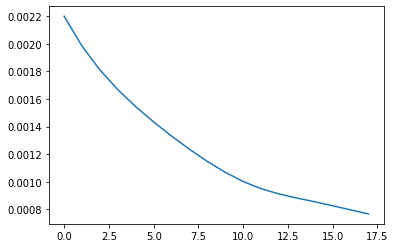

In [34]:
plt.plot(regr.loss_curve_)

In [35]:
dm = cdist(pred_main_emb, valid_mimic_emb, 'euclidean')
# euclidean, seuclidean, cosine, correlation, chebyshev
match_idx = np.argmin(dm, axis=1)

In [36]:
calculate_metrics(match_idx, main_emb[match_index])

len 7332
accuracy 0.0008183306055646482
global average cos similarity 0.16782591
predict average cos similarity 0.2384503037306499


(0.0008183306055646482, 0.2384503037306499)

## Procrustes baseline

In [37]:
from procrustes.orthogonal import orthogonal
from procrustes.generic import generic
from procrustes.rotational import rotational
from procrustes.orthogonal import orthogonal_2sided

def procrustes_train(model):
    print('train num', train_main_emb.shape[0])
    if model == 'orthogonal':
        result = orthogonal(train_main_emb, train_mimic_emb, translate=translate, scale=scale)
    elif model == 'generic':
        result = generic(train_main_emb, train_mimic_emb, translate=translate, scale=scale)
    elif model == 'rotational':
        result = rotational(train_main_emb, train_mimic_emb, translate=translate, scale=scale)
    elif model == 'orthogonal_2sided':
        result = orthogonal_2sided(train_main_emb, train_mimic_emb, translate=translate, scale=scale, single=False)
    
    pred_main_emb = valid_main_emb@result.t
    dm = cdist(pred_main_emb, valid_mimic_emb, 'euclidean')
    match_idx = np.argmin(dm, axis=1)
    
    acc, cos = calculate_metrics(match_idx, valid_main_emb)
    
model = 'rotational'
translate = True
scale = False
procrustes_train(model)

train num 200
len 7332
accuracy 0.5875613747954174
global average cos similarity 0.104153655
predict average cos similarity 0.8537725520407119


### MultiLabel Linear Regression

In [38]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, ARDRegression, MultiTaskLasso, ElasticNet

model = MultiOutputRegressor(LinearRegression()).fit(train_main_emb, train_mimic_emb)
# model = MultiOutputRegressor(Lasso(alpha=0.1)).fit(train_main_emb, train_mimic_emb)
# model = MultiOutputRegressor(ElasticNet()).fit(train_main_emb, train_mimic_emb)
# model = MultiTaskLasso(alpha=0.0001).fit(train_main_emb, train_mimic_emb)
# model = MultiOutputRegressor(AdaBoostRegressor()).fit(train_main_emb, train_mimic_emb)

pred_main_emb = model.predict(valid_main_emb)

dm = cdist(pred_main_emb, valid_mimic_emb, 'euclidean')
match_idx = np.argmin(dm, axis=1)

acc, cos = calculate_metrics(match_idx, valid_main_emb)

len 7332
accuracy 0.4849972722313148
global average cos similarity 0.111071
predict average cos similarity 0.7814110289228723


### Grid search select num

In [39]:
mlp_result = {}
p1_result = {}
p2_result = {}

for select_num in [20, 40, 100, 200, 400, 1000, 2000, 3000]:
    print(select_num)
    anchor_index = np.random.choice(np.arange(n), size=select_num, replace=False)
    match_index = np.delete(np.arange(n), anchor_index)

    train_main_emb = main_emb[anchor_index]
    valid_main_emb = main_emb[match_index]

    train_mimic_emb = mimic_emb[anchor_index]
    valid_mimic_emb = mimic_emb[match_index]

    regr = MLPRegressor(random_state=1, max_iter=500).fit(train_main_emb, train_mimic_emb)
    pred_main_emb = regr.predict(valid_main_emb)
    dm = cdist(pred_main_emb, valid_mimic_emb, 'euclidean')
    match_idx = np.argmin(dm, axis=1)
    acc, cos = calculate_metrics(match_idx, main_emb[match_index])
    
    mlp_result[select_num] = acc, cos
    
    result = orthogonal(train_main_emb, train_mimic_emb, translate=True, scale=False)
    pred_main_emb = valid_main_emb@result.t
    dm = cdist(pred_main_emb, valid_mimic_emb, 'euclidean')
    match_idx = np.argmin(dm, axis=1)
    acc, cos = calculate_metrics(match_idx, valid_mimic_emb)
    
    p1_result[select_num] = acc, cos
    
    result = generic(train_main_emb, train_mimic_emb, translate=True, scale=False)
    pred_main_emb = valid_main_emb@result.t
    dm = cdist(pred_main_emb, valid_mimic_emb, 'euclidean')
    match_idx = np.argmin(dm, axis=1)
    acc, cos = calculate_metrics(match_idx, valid_mimic_emb)
    
    p2_result[select_num] = acc, cos

20
len 7512
accuracy 0.0011980830670926517
global average cos similarity 0.16081566
predict average cos similarity 0.1905797728842186
len 7512
accuracy 0.007987220447284345
global average cos similarity 0.15237607
predict average cos similarity 0.320189942186252
len 7512
accuracy 0.005857294994675187
global average cos similarity 0.16199566
predict average cos similarity 0.32986290944904817
40
len 7492
accuracy 0.0009343299519487453
global average cos similarity 0.14573649
predict average cos similarity 0.20137111095585292
len 7492
accuracy 0.035371062466631076
global average cos similarity 0.14932095
predict average cos similarity 0.4080829447243727
len 7492
accuracy 0.04578216764548852
global average cos similarity 0.14672743
predict average cos similarity 0.4143876515157835
100
len 7432
accuracy 0.00013455328310010763
global average cos similarity 0.16333526
predict average cos similarity 0.20401286770889399
len 7432
accuracy 0.2586114101184069
global average cos similarity 0.156243

In [40]:
cols = ['accuracy', 'average cos']
mlp_df = pd.DataFrame(mlp_result).T
mlp_df.columns = cols
p1_df = pd.DataFrame(p1_result).T
p1_df.columns = cols
p2_df = pd.DataFrame(p2_result).T
p2_df.columns = cols

In [41]:
res = pd.concat([mlp_df, p1_df, p2_df], axis=1)

arrays = [['mlp', 'mlp', 'orthogonal procrustes', 'orthogonal procrustes', 'generic procrustes', 'generic procrustes'], res.columns]
new_cols = pd.MultiIndex.from_arrays(arrays, names=('model', ''))

res.columns = new_cols
res

model       mlp             orthogonal procrustes              \
       accuracy average cos              accuracy average cos   
20     0.001198    0.190580              0.007987    0.320190   
40     0.000934    0.201371              0.035371    0.408083   
100    0.000135    0.204013              0.258611    0.639016   
200    0.000955    0.232408              0.586061    0.849767   
400    0.000561    0.255139              0.782810    0.939887   
1000   0.006124    0.340389              0.878751    0.972972   
2000   0.048807    0.454882              0.912509    0.981694   
3000   0.118491    0.524947              0.925199    0.984361   

model generic procrustes              
                accuracy average cos  
20              0.005857    0.329863  
40              0.045782    0.414388  
100             0.284849    0.650899  
200             0.543781    0.821699  
400             0.624509    0.854972  
1000            0.790570    0.938769  
2000            0.878706    0.971685  
3000            0.908870    0.980804

## Plot Umap Result
simple 20news umap result

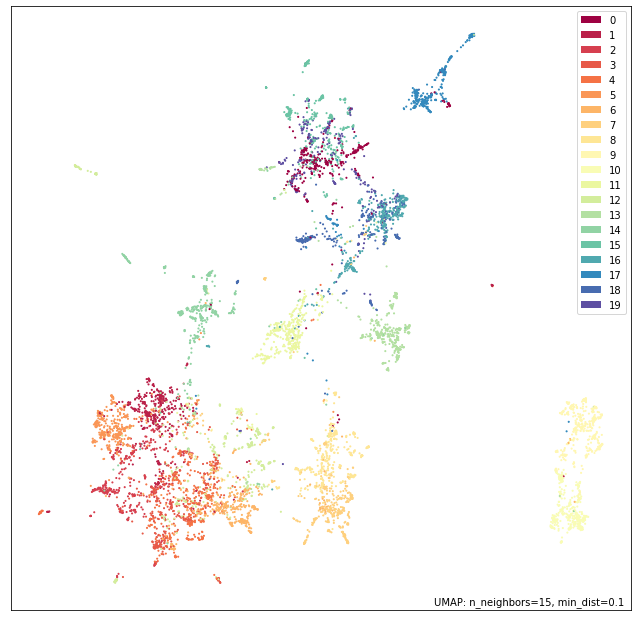

In [42]:
# https://umap-learn.readthedocs.io/en/latest/parameters.html
# https://umap-learn.readthedocs.io/en/latest/document_embedding.html
main_emb_plot = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', random_state=33).fit(main_emb)
f = umap.plot.points(main_emb_plot, labels=news_data.target)